In [ ]:
from email import message
from dotenv import load_dotenv
from typing import Annotated, Literal
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from IPython.display import Image, display

load_dotenv()

llm = init_chat_model("anthropic:claude-sonnet-4-20250514")

class MessageClassifier(BaseModel):
    message_type: Literal["Order", "Email", "Policy", "QA", "Message"] = Field(
        ...,
        description="Classify if the user message is related to orders, emails, policy, general question and answer, or messaging."
    )

class State(TypedDict):
    messages: Annotated[list, add_messages]
    message_type: str

def classify_message(state: State):
    last_message = state["messages"][-1]
    classifier_llm = llm.with_structured_output(MessageClassifier)

    result = classifier_llm.invoke([
        {
            "role": "system",
            "content": """Classify the user message as one of the following:
            - 'Order': if the user asks about order information such as shipping status, price, order quantity, etc.
            - 'Email': if the user mentions anything related to email or if they inquire about information that could be sent to them in a structured email
            - 'QA': if the user asks a question about something other than the order, that is they ask about anything not related to a specific task 
            - 'Policy': if the user asks a question about returns, shipping times, or any other information that seems to be related to company policy
            - 'Message': if the user asks a question about anything that would warrant an immediate response in the form of a structured chat message"""
        },
        {"role": "user", "content": last_message.content}
    ])
    return {"message_type": result.message_type}

def router(state: State):
    message_type = state.get("message_type", "QA")
    if message_type == "Order":
        return {"next": "order"}
    if message_type == "Email":
        return {"next": "email"}
    if message_type == "Policy":
        return {"next": "policy"}
    if message_type == "QA":
        return {"next": "QA"}
    if message_type == "Message":
        return {"next": "message"}
    return {"next": "QA"}

def order_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
        "content": """You are an order agent. Your job is to help customers with information related to their orders. You can
        fetch orders based on order number, tell the user what the shipping status of their order is, and when orders are created,
        you are to create an autonomous, standardized response."""
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}

def email_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
        "content": """You are an email agent. Your job is to help customers by delivering data in a structured format via email."""
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}

def policy_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
        "content": """You are a policy agent. Your job is to help customers with questions that appear to be related to company policy,
        such as how long deliveries usually take, how returns are handled, and how the company runs things. You are to refer to the written policy
        and inform the user how to contact the store when information can't be retrieved for one reason or another."""
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}

def QA_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
        "content": """You are a QA agent. Your job is to help customers with their general questions that do not seem to be related to
        orders or policy. Stay professional and refer the user to other agents if the topic seems to be leaning towards policy, orders,
        shipping, etc."""
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}

def message_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
        "content": """You are a message agent. Your job is to provide structured responses and help the customer the best that you can.
        Refer the relevant information from the user's request to the orchestrator agent in a structured manner so that customers can
        be helped with their specific use case."""
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}

def orchestrator_agent(state: State):
    last_message = state["messages"][-1]

    messages = [
        {"role": "system",
        "content": """You are an orchestrator agent. Your job is to receive information from the other AI agents and ensure that
        the information is all-encompassing, thoroughly retrieved, and finished. If the information is incomplete, try your best
        to communicate with the other agents to complete the information, and if after you have done that, the information is still
        incomplete, inform the user that they can contact the company directly and their case will be documented for oversight."""
        },
        {
            "role": "user",
            "content": last_message.content
        }
    ]
    reply = llm.invoke(messages)
    return {"messages": [{"role": "assistant", "content": reply.content}]}


graph_builder = StateGraph(State)
graph_builder.add_node("router", router)
graph_builder.add_node("order", order_agent)
graph_builder.add_node("email", email_agent)
graph_builder.add_node("policy", policy_agent)
graph_builder.add_node("QA", QA_agent)
graph_builder.add_node("message", message_agent)
graph_builder.add_node("orchestrator", orchestrator_agent)
graph_builder.add_edge(START, "router")
graph_builder.add_conditional_edges(
    "router",
    lambda state: state.get("next"),
    {
        "order": "order", 
        "email": "email", 
        "policy": "policy", 
        "QA": "QA", 
        "message": "message"
    }
)
graph_builder.add_edge("order", "orchestrator")
graph_builder.add_edge("email", "orchestrator")
graph_builder.add_edge("policy", "orchestrator")
graph_builder.add_edge("QA", "orchestrator")
graph_builder.add_edge("message", "orchestrator")

graph_builder.add_edge("orchestrator", END)
graph = graph_builder.compile()

def run_chatbot():
    state = {"messages": [], "message_type": None}

    while True:
        user_input = input("Message: ")
        if user_input == "exit":
            print("Bye")
            break

        state["messages"] = state.get("messages", []) + [
            {"role": "user", "content": user_input}
        ]

        state = graph.invoke(state)

        if state.get("messages") and len(state["messages"]) > 0:
            last_message = state["messages"][-1]
            print(f"Assistant: {last_message.content}")

if __name__ == "__main__":
    run_chatbot()

Assistant: I'd be happy to help you with your order! To provide you with the most accurate assistance, I'll need to gather some information from you first.

Could you please provide me with:

1. **Your order number** (if you have it)
2. **The email address** associated with your order
3. **What specific help you need** - for example:
   - Order status/tracking
   - Making changes to an order
   - Cancellation request
   - Return or refund
   - Product questions
   - Delivery issues

Once I have these details, I can coordinate with our specialized agents to get you comprehensive information about your order and resolve any issues you're experiencing.

What's your order number and how can I assist you today?


BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'messages.0: all messages must have non-empty content except for the optional final assistant message'}, 'request_id': 'req_011CSqd1ozsXLSvYPvhUGsNc'}

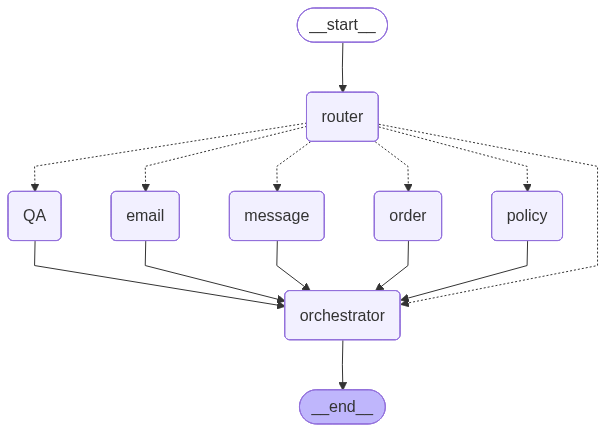

In [6]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass